### Load Data

In [89]:
import os, pandas as pd, numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('max.columns', 500)

In [90]:
from backtest.data_load import create_historical_df
from backtest.create_features import averages, lag, poly, dummy, mean_revert, injury_columns

In [91]:
link = '../data/fantasy_nerd/'
end_date = '2019-03-03'

In [92]:
hist_raw = create_historical_df(link, end_date)

In [93]:
hist = hist_raw.copy()

In [94]:
cols = ['Proj_FP', 'Likes', 'Rest', 'Salary', 'S_FP', 'Proj_Min']

In [95]:
hist = hist[hist.Proj_FP >= 15]

### Make Predictions

In [96]:
from sklearn.preprocessing import Normalizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge, Lasso, LinearRegression, BayesianRidge, RidgeCV, LassoCV, TheilSenRegressor, ARDRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [97]:
hist_cp = hist[(hist.Inj==0)].copy()
optimizer_df = pd.DataFrame(columns=[
            'Player_Name',
            'FDP_predicted',
            'Salary',
            'Pos',
            'Date',
            'FDP_error',
            'FDP_actual',
            'Team',
            'Opp'
])

for date in hist_cp.sort_values(by="Date").Date.unique():
    print(date)
    ### Load data upto date, make sure there is data available
    tmp_df = hist_cp[hist_cp.Date <= date].dropna()
    
    if tmp_df[tmp_df.Date < date].shape[0] == 0:
        continue
    
    ### Create X, y data to train
    X = tmp_df.loc[tmp_df.Date < date, cols]
    y = tmp_df[tmp_df.Date < date]['Actual_FP'].values
    ###############################################
    ####################   MODEL BUILDLING
    ###############################################
    linear = Ridge(fit_intercept=False)
    linear.fit(X, y)
    
    preds_df = tmp_df[tmp_df.Date == date]
    if preds_df.shape[0] == 0:
        continue
        
    preds = linear.predict(preds_df[cols])
    preds_df['FDP_predicted'] = preds
    preds_df['FDP_error'] = preds_df['Actual_FP'] - preds_df['FDP_predicted']
    
    preds_df.rename(columns={'Actual_FP': 'FDP_actual'}, inplace=True)
    optimizer_df = optimizer_df.append(
        preds_df[[
            'Player_Name',
            'FDP_predicted',
            'Salary',
            'Pos',
            'Date',
            'FDP_error',
            'FDP_actual',
            'Team',
            'Opp'
        ]]
    )

2018-10-16
2018-10-17
2018-10-18
2018-10-19
2018-10-20
2018-10-21
2018-10-22
2018-10-23
2018-10-24
2018-10-25
2018-10-26
2018-10-27
2018-10-28
2018-10-29
2018-10-30
2018-10-31
2018-11-01
2018-11-02
2018-11-03
2018-11-04
2018-11-05
2018-11-06
2018-11-07
2018-11-08
2018-11-09
2018-11-10
2018-11-11
2018-11-12
2018-11-13
2018-11-14
2018-11-15
2018-11-16
2018-11-17
2018-11-18
2018-11-19
2018-11-20
2018-11-21
2018-11-23
2018-11-24
2018-11-25
2018-11-26
2018-11-27
2018-11-28
2018-11-29
2018-11-30
2018-12-01
2018-12-02
2018-12-03
2018-12-04
2018-12-05
2018-12-06
2018-12-07
2018-12-08
2018-12-09
2018-12-10
2018-12-11
2018-12-12
2018-12-13
2018-12-14
2018-12-15
2018-12-16
2018-12-17
2018-12-18
2018-12-19
2018-12-21
2018-12-22
2018-12-23
2018-12-25
2018-12-26
2018-12-27
2018-12-28
2018-12-29
2018-12-30
2018-12-31
2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17

In [98]:
optimizer_df['FDP_predicted'] = np.where(optimizer_df['FDP_predicted'].abs()>90, 90, optimizer_df['FDP_predicted'])

In [99]:
(optimizer_df.FDP_error**2).mean()**0.5

9.879500728200087

In [12]:
tmp = optimizer_df.groupby(['Date', 'Pos']).max().reset_index()
optimizer_df = tmp[tmp.Pos=='C'].append(optimizer_df[optimizer_df.Pos != 'C'])

### Backtest Results

In [23]:
from backtest.backtest import Optimizer, Backtest

In [14]:
o = Optimizer(optimizer_df)

In [15]:
b = Backtest(o)

In [16]:
b.create_backtest_df()

In [17]:
b.backtest_df

,players_2018-10-19,FDP_predicted_2018-10-19,FDP_actual_2018-10-19,players_2018-10-20,FDP_predicted_2018-10-20,FDP_actual_2018-10-20,players_2018-10-21,FDP_predicted_2018-10-21,FDP_actual_2018-10-21,players_2018-10-22,FDP_predicted_2018-10-22,FDP_actual_2018-10-22,players_2018-10-23,FDP_predicted_2018-10-23,FDP_actual_2018-10-23,players_2018-10-24,FDP_predicted_2018-10-24,FDP_actual_2018-10-24,players_2018-10-25,FDP_predicted_2018-10-25,FDP_actual_2018-10-25,players_2018-10-26,FDP_predicted_2018-10-26,FDP_actual_2018-10-26,players_2018-10-27,FDP_predicted_2018-10-27,FDP_actual_2018-10-27,players_2018-10-28,FDP_predicted_2018-10-28,FDP_actual_2018-10-28,players_2018-10-29,FDP_predicted_2018-10-29,FDP_actual_2018-10-29,players_2018-10-30,FDP_predicted_2018-10-30,FDP_actual_2018-10-30,players_2018-10-31,FDP_predicted_2018-10-31,FDP_actual_2018-10-31,players_2018-11-01,FDP_predicted_2018-11-01,FDP_actual_2018-11-01,players_2018-11-02,FDP_predicted_2018-11-02,FDP_actual_2018-11-02,players_2018-11-03,FDP_predicted_2018-11-03,FDP_actual_2018-11-03,players_2018-11-04,FDP_predicted_2018-11-04,FDP_actual_2018-11-04,players_2018-11-05,FDP_predicted_2018-11-05,FDP_actual_2018-11-05,players_2018-11-06,FDP_predicted_2018-11-06,FDP_actual_2018-11-06,players_2018-11-07,FDP_predicted_2018-11-07,FDP_actual_2018-11-07,players_2018-11-08,FDP_predicted_2018-11-08,FDP_actual_2018-11-08,players_2018-11-09,FDP_predicted_2018-11-09,FDP_actual_2018-11-09,players_2018-11-10,FDP_predicted_2018-11-10,FDP_actual_2018-11-10,players_2018-11-11,FDP_predicted_2018-11-11,FDP_actual_2018-11-11,players_2018-11-12,FDP_predicted_2018-11-12,FDP_actual_2018-11-12,players_2018-11-13,FDP_predicted_2018-11-13,FDP_actual_2018-11-13,players_2018-11-14,FDP_predicted_2018-11-14,FDP_actual_2018-11-14,players_2018-11-15,FDP_predicted_2018-11-15,FDP_actual_2018-11-15,players_2018-11-16,FDP_predicted_2018-11-16,FDP_actual_2018-11-16,players_2018-11-17,FDP_predicted_2018-11-17,FDP_actual_2018-11-17,players_2018-11-18,FDP_predicted_2018-11-18,FDP_actual_2018-11-18,players_2018-11-19,FDP_predicted_2018-11-19,FDP_actual_2018-11-19,players_2018-11-20,FDP_predicted_2018-11-20,FDP_actual_2018-11-20,players_2018-11-21,FDP_predicted_2018-11-21,FDP_actual_2018-11-21,players_2018-11-23,FDP_predicted_2018-11-23,FDP_actual_2018-11-23,players_2018-11-24,FDP_predicted_2018-11-24,FDP_actual_2018-11-24,players_2018-11-25,FDP_predicted_2018-11-25,FDP_actual_2018-11-25,players_2018-11-26,FDP_predicted_2018-11-26,FDP_actual_2018-11-26,players_2018-11-27,FDP_predicted_2018-11-27,FDP_actual_2018-11-27,players_2018-11-28,FDP_predicted_2018-11-28,FDP_actual_2018-11-28,players_2018-11-29,FDP_predicted_2018-11-29,FDP_actual_2018-11-29,players_2018-11-30,FDP_predicted_2018-11-30,FDP_actual_2018-11-30,players_2018-12-01,FDP_predicted_2018-12-01,FDP_actual_2018-12-01,players_2018-12-02,FDP_predicted_2018-12-02,FDP_actual_2018-12-02,players_2018-12-03,FDP_predicted_2018-12-03,FDP_actual_2018-12-03,players_2018-12-04,FDP_predicted_2018-12-04,FDP_actual_2018-12-04,players_2018-12-05,FDP_predicted_2018-12-05,FDP_actual_2018-12-05,players_2018-12-06,FDP_predicted_2018-12-06,FDP_actual_2018-12-06,players_2018-12-07,FDP_predicted_2018-12-07,FDP_actual_2018-12-07,players_2018-12-08,FDP_predicted_2018-12-08,FDP_actual_2018-12-08,players_2018-12-09,FDP_predicted_2018-12-09,FDP_actual_2018-12-09,players_2018-12-10,FDP_predicted_2018-12-10,FDP_actual_2018-12-10,players_2018-12-11,FDP_predicted_2018-12-11,FDP_actual_2018-12-11,players_2018-12-12,FDP_predicted_2018-12-12,FDP_actual_2018-12-12,players_2018-12-13,FDP_predicted_2018-12-13,FDP_actual_2018-12-13,players_2018-12-14,FDP_predicted_2018-12-14,FDP_actual_2018-12-14,players_2018-12-15,FDP_predicted_2018-12-15,FDP_actual_2018-12-15,players_2018-12-16,FDP_predicted_2018-12-16,FDP_actual_2018-12-16,players_2018-12-17,FDP_predicted_2018-12-17,FDP_actual_2018-12-17,players_2018-12-18,FDP_predicted_2018-12-18,FDP_actual_2018-12-18,players_2018-12-19,FDP_predicted_2018-1

In [18]:
b.backtest_results(drop_lowest=True)

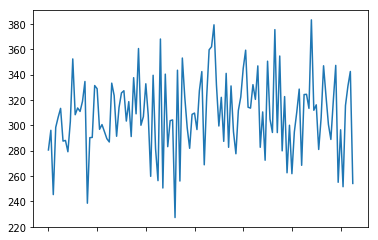

In [19]:
b.results.actual_sum.plot()

In [20]:
b.results.actual_sum.mean()

309.1555555555555

In [63]:
b.results.actual_sum.mean()

302.708

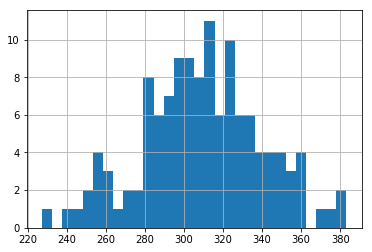

In [21]:
b.results.actual_sum.hist(bins=30)

In [22]:
b.results.actual_sum.std()

30.643771453411034

In [23]:
(b.results.actual_sum < 300).mean()

0.373015873015873

In [24]:
b.results

,actual_sum,error,predicted_sum
2018-10-19,280.6,8.866716,271.733284
2018-10-20,296.1,3.046977,293.053023
2018-10-21,245.4,-48.147220,293.547220
2018-10-22,298.4,9.263687,289.136313
2018-10-23,306.4,19.791015,286.608985
2018-10-24,313.4,27.390845,286.009155
2018-10-25,287.6,10.943159,276.656841
2018-10-26,288.1,-6.533312,294.633312
2018-10-27,279.2,-10.666294,289.866294
2018-10-28,303.0,11.009498,291.990502


## Make New Predictions

In [100]:
fd = pd.read_csv('../data/predictions/FanDuel-NBA-2019-03-03-33219-players-list.csv')

df = pd.read_csv('../data/predictions/DFN NBA FD 3_3.csv')

fd = fd[[
    'Position',
    'Nickname',
    'Salary'
]].rename(columns={
    'Position': 'Pos',
    'Nickname': 'Player_Name'
})


df.columns = [x.replace(' ', '_') for x in df.columns]
#df.drop(columns=['Opp_Pace', 'Opp_DEff', 'Floor_FP', 'PS', 'USG', 'PER', 'Opp_DvP'], inplace=True)

arrange = X.columns

In [101]:
fd['Player_Name'] = fd['Player_Name'].str.replace('-', ' ')
fd['Player_Name'] = fd['Player_Name'].str.replace(' Jr', '')
fd['Player_Name'] = fd['Player_Name'].str.replace('.', '')
fd['Player_Name'] = fd['Player_Name'].str.replace("'", '')
fd['Player_Name'] = fd['Player_Name'].str.replace(' III', '')
fd['Player_Name'] = fd['Player_Name'].str.replace(' IV', '')
df['Player_Name'] = df['Player_Name'].str.replace('-', ' ')
df['Player_Name'] = df['Player_Name'].str.replace(' Jr', '')
df['Player_Name'] = df['Player_Name'].str.replace('.', '')
df['Player_Name'] = df['Player_Name'].str.replace("'", '')
df['Player_Name'] = df['Player_Name'].str.replace(' III', '')
df['Player_Name'] = df['Player_Name'].str.replace(' IV', '')


df.replace(
    {'Player_Name': {
        'Patrick Mills': 'Patty Mills',
        'Domas Sabonis': 'Domantas Sabonis',
        'Dave Bertans': 'Davis Bertans',
        'Naz Long': 'Naz Mitrou Long',
        'Juan Hernangomez': 'Juancho Hernangomez',
        'Wesley Iwundu': 'Wes Iwundu',
        'Brad Beal': 'Bradley Beal',
        'Ishmael Smith': 'Ish Smith',
        'Patrick Mccaw': 'Patrick McCaw',
        'Sviatoslav Mykhailiuk': 'Svi Mykhailiuk'
    }}, inplace=True
)

In [102]:
if len(fd.Player_Name.unique()) != len(df[(df.Team != 'DET')&(df.Team != 'CLE')].Player_Name.unique()):
    for name in fd.Player_Name.unique():
        if name not in df.Player_Name.unique():
            print(name)
else:
    print(True)

Fred VanVleet
Mo Bamba


In [103]:
cols = ['Inj', 'Likes']

for col in cols:
    df[col] = np.where(df[col].isnull(), 0, df[col])

df = df[(df.Inj==0)]

In [104]:
fd = fd.merge(df, on=['Player_Name', 'Pos', 'Salary'], copy=False)

fd['Home'] = np.where(
      fd['Opp'].str.contains('@'), 
      1, 
      0
      )

In [105]:
# fd = fd[
#     (fd.Pos != 'C') | 
#     (fd.Pos == 'C') & (fd.Proj_Val == fd[fd.Pos=='C'].Proj_Val.max())
# ]

In [106]:
fd.Team.unique()

array(['MIN', 'OKC', 'DET', 'ORL', 'WAS', 'TOR', 'CLE', 'MEM'],
      dtype=object)

In [107]:
# #teams = ['OKC', 'SAS', 'MEM', 'DAL', 'GSW', 'PHI']                                          #830
# teams = ['LAL', 'PHO', 'NOR', 'DEN', 'MIL', 'UTA']                                          #900

# fd = fd[fd.Team.isin(teams)]

In [108]:
fd.Team.unique()

array(['MIN', 'OKC', 'DET', 'ORL', 'WAS', 'TOR', 'CLE', 'MEM'],
      dtype=object)

In [109]:
fd = fd[fd['Proj_FP'] >= 15]
fd['FDP_predicted'] = linear.predict(fd[arrange])
fd = fd[['Player_Name', 'FDP_predicted', 'Salary', "Pos", 'Team']]

In [110]:
t = Optimizer(fd, salary_cap=60000, max_players=9, team_mems=4)
names = t.optimize().Player_Name
optimal = fd[(fd.Player_Name.isin(names))]

In [111]:
optimal.sort_values(by='Pos')

,Player_Name,FDP_predicted,Salary,Pos,Team
17,Marc Gasol,30.698102,6100,C,TOR
9,Pascal Siakam,36.367805,7600,PF,TOR
23,Larry Nance,27.238295,5600,PF,CLE
1,Russell Westbrook,55.709483,11600,PG,OKC
27,Tomas Satoransky,28.931820,5500,PG,WAS
54,Bruno Caboclo,19.731871,3600,SF,MEM
98,CJ Miles,15.913510,3500,SF,MEM
4,Bradley Beal,49.751497,10000,SG,WAS
13,Andrew Wiggins,32.459619,6500,SG,MIN


In [74]:
optimal.sort_values(by='Pos')

,Player_Name,FDP_predicted,Salary,Pos,Team
17,Marc Gasol,30.682525,6100,C,TOR
9,Pascal Siakam,36.361577,7600,PF,TOR
23,Larry Nance,27.242227,5600,PF,CLE
1,Russell Westbrook,55.679083,11600,PG,OKC
27,Tomas Satoransky,28.909442,5500,PG,WAS
54,Bruno Caboclo,19.731004,3600,SF,MEM
98,CJ Miles,15.925238,3500,SF,MEM
4,Bradley Beal,49.721375,10000,SG,WAS
13,Andrew Wiggins,32.440358,6500,SG,MIN


In [112]:
optimal.Salary.sum(), optimal.FDP_predicted.sum()

(60000, 296.80200178417135)